In [1]:
%matplotlib inline

In [2]:
import hcipy as hci
import numpy as np
import matplotlib.pyplot as plt

#from field_max import imshow_fieldv2

In [3]:
import plot as meplot

In [4]:
plt.rcParams['figure.figsize'] = (13, 6)
plt.rcParams['image.origin'] = True

In [5]:
from matplotlib.colors import LogNorm
import psfModels as pM
import fit_psf as fp

In [6]:
def slicemap(map, normalised=True):
    """Cut out the row at size/2 and normalize."""
    
    if normalised==True:
        return map[:,map.shape[0]//2] / map.max()
    else:
        return map[:,map.shape[0]//2]


def sumit(map, normalised=True, slice_middle=True):
    """Sum on columns and normalize."""
    
    if normalised:
        return  map.sum(0) / map.sum(0).max()
    else:
        return  map.sum(0)

## Parameters and run HCIPy simulation

In [7]:
%%time

################# Parameters #################
wvlgth = 1e-6 #666e-9  

diam_aperture = 1.2           
focal_length = 18*diam_aperture 

diam_obs = 0.3/diam_aperture                                 # obscuration ratio
spid_width = 0.05                                            # [m]

grid_size_pix = 1024
grid_diam = 1.5*diam_aperture #si on change, baisse pbbly quality

pupil_grid = hci.make_pupil_grid(grid_size_pix, grid_diam)  #It's a computational grid, nothing physical


################# Aperture Auxtel #################
central_obs = hci.aperture.make_obstructed_circular_aperture(diam_aperture, diam_obs)
spider_1 = hci.aperture.make_spider([0,0], [0.6,0.6], spid_width)         # [m][m]
spider_2 = hci.aperture.make_spider([0,0], [0.6,-0.6], spid_width)        # [m][m]
spider_3 = hci.aperture.make_spider([0,0], [-0.6,0.6], spid_width)        # [m][m]
spider_4 = hci.aperture.make_spider([0,0], [-0.6,-0.6], spid_width)       # [m][m]

tel_pupil = central_obs(pupil_grid)*spider_1(pupil_grid)*spider_2(pupil_grid)*spider_3(pupil_grid)*spider_4(pupil_grid)

wf = hci.Wavefront(tel_pupil, wvlgth)


################# Sampling #################
sampl_focal = 32                            #échantillonage q (8 pix per λ/D) 
fov = 8                                     # [λ/D], radius

focal_grid = hci.make_focal_grid(pupil_grid, sampl_focal, fov)


################# Atmosphere parameters #################
seeing = 1.0 

fried_parameter = 0.2#0.98 * wvlgth/seeing * (180/np.pi) * 3600  # [m]
outer_scale = 20                                             # [m], "L0"

Cn_squared = hci.Cn_squared_from_fried_parameter(fried_parameter, wvlgth)


################# Propagation #################
prop = hci.FraunhoferPropagator(pupil_grid, focal_grid, wvlgth, 10000*focal_length)

nblayers = 100
avg_intensity = 0
for i in range (nblayers):
    layer = hci.FiniteAtmosphericLayer(pupil_grid, Cn_squared)  #finit or infinite ?
    temp_img = prop(layer(wf))
    avg_intensity += temp_img.intensity              # can't add wavefront objects, need to directly add intensity
    #foc_img_atmtable.append(temp_img)
avg_intensity /= nblayers

/home/novae/rey/anaconda3/lib/python3.7/site-packages/hcipy/fourier/fast_fourier_transform.py:81: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f[self.cutout_output] = (field.ravel() / self.shift_input).reshape(self.shape_out)
/home/novae/rey/anaconda3/lib/python3.7/site-packages/hcipy/fourier/fast_fourier_transform.py:83: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = res[self.cutout_input].ravel() / self.weights / self.shift_output


CPU times: user 13min 58s, sys: 6.81 s, total: 14min 5s
Wall time: 3min 38s


In [8]:
foc_img = prop(wf)

## **Plots**

/home/novae/rey/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


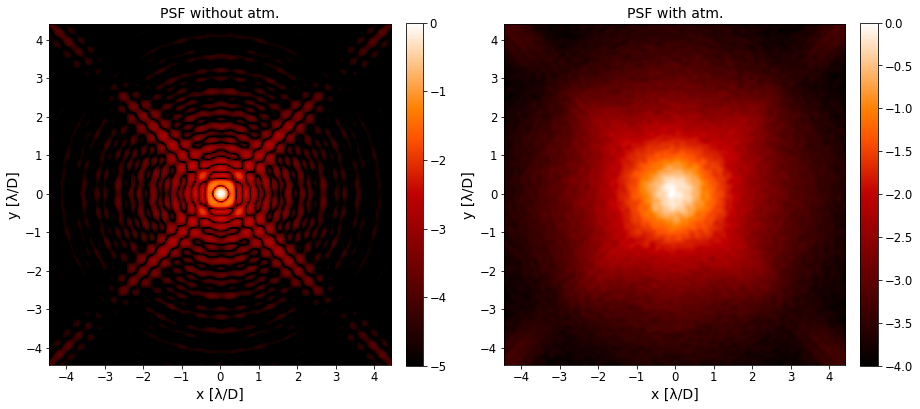

In [9]:
plt.subplot(1, 2, 1)
hci.imshow_field(np.log10(foc_img.intensity / foc_img.intensity.max()),cmap='gist_heat', vmin=-5)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('PSF without atm.')

plt.subplot(1, 2, 2)
hci.imshow_field(np.log10(avg_intensity / avg_intensity.max()),cmap='gist_heat', vmin=-4)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('x [λ/D]')
plt.ylabel('y [λ/D]')
plt.title('PSF with atm.')

plt.tight_layout()
plt.savefig('HCIPy_atmosphere_avg')
plt.show()


## **PSF in 2D (slice or sum)**

In [10]:
map_1 = foc_img.intensity.shaped                         # Take intensity and reshape (1D -> 2D)
map_2 = avg_intensity.shaped

xaxis_1 = focal_grid.x.reshape(map_1.shape)[0,:]
xaxis_2 = focal_grid.x.reshape(map_2.shape)[0,:]

In [11]:
psf_1_slice = slicemap(map_1, normalised=False)
psf_2_slice = slicemap(map_2, normalised=False)
psf_1_sum = sumit(map_1, normalised=False)
psf_2_sum = sumit(map_2, normalised=False)

# Analytic kolmogorov

In [12]:
size_array = 100                                            # [pixels]           (i.e. size of map)
shape = (size_array,size_array)                                            # [] size of the grid

x, y = fp.create_coords(shape, starts='auto', steps=0.401, sparse=True)
radius = np.hypot(x, y)

psf_Hank = pM.psf_Kolmogorov_Hankel(radius, wvlgth, r0=fried_parameter)

    
me_x_axis = np.linspace(0,5)
index = [4/3, 3/2, 5/3, 11/6]
    
test_psf1 = pM.psf_Kolmogorov_Hankel(me_x_axis, wvlgth, r0=fried_parameter, expo=4/3)
test_psf2 = pM.psf_Kolmogorov_Hankel(me_x_axis, wvlgth, r0=fried_parameter, expo=3/2)
test_psf3 = pM.psf_Kolmogorov_Hankel(me_x_axis, wvlgth, r0=fried_parameter, expo=5/3)
test_psf4 = pM.psf_Kolmogorov_Hankel(me_x_axis, wvlgth, r0=fried_parameter, expo=11/6)

/home/novae/rey/Desktop/Stage/kolmogorov/hankelTransform.py:2477: RuntimeWarning: divide by zero encountered in true_divide
  return N.dot(w, g(p/k[..., N.newaxis]).swapaxes(-1, -2)) / k
/home/novae/rey/Desktop/Stage/kolmogorov/hankelTransform.py:2474: RuntimeWarning: invalid value encountered in multiply
  def g(r): return r*f(r)


# Realisation (HCIPy) VS analytical result

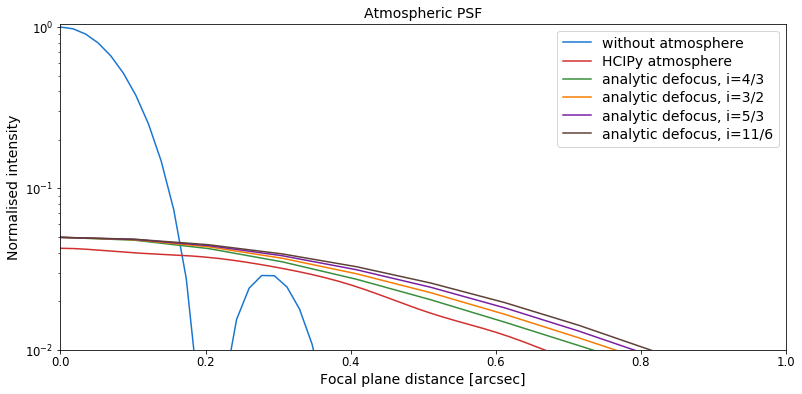

In [17]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)

ax1.plot(xaxis_1, psf_1_slice/psf_1_slice.max(), label='without atmosphere')
ax1.plot(xaxis_2*1.05, psf_2_slice/psf_1_slice.max(), label='HCIPy atmosphere')
ax1.plot(me_x_axis, test_psf1/psf_1_slice.max(), label='analytic defocus, i=4/3')
ax1.plot(me_x_axis, test_psf2/psf_1_slice.max(), label='analytic defocus, i=3/2')
ax1.plot(me_x_axis, test_psf3/psf_1_slice.max(), label='analytic defocus, i=5/3')
ax1.plot(me_x_axis, test_psf4/psf_1_slice.max(), label='analytic defocus, i=11/6')
ax1.set_xlabel('Focal plane distance [arcsec]')
ax1.set_ylabel('Normalised intensity')
ax1.set_ylim(bottom=10**-2)
ax1.set_xlim(left=-0, right=1)
ax1.set_title('Atmospheric PSF')
ax1.set_yscale('log')
ax1.legend()

plt.savefig("comp_hcipy_analytic")